# DengAI competition
https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [13]:
train_f = pd.read_csv('dengue_features_train.csv')

In [14]:
train_labels = pd.read_csv('dengue_labels_train.csv')

In [15]:
train = train_f.copy()
train['total_cases'] = train_labels['total_cases']

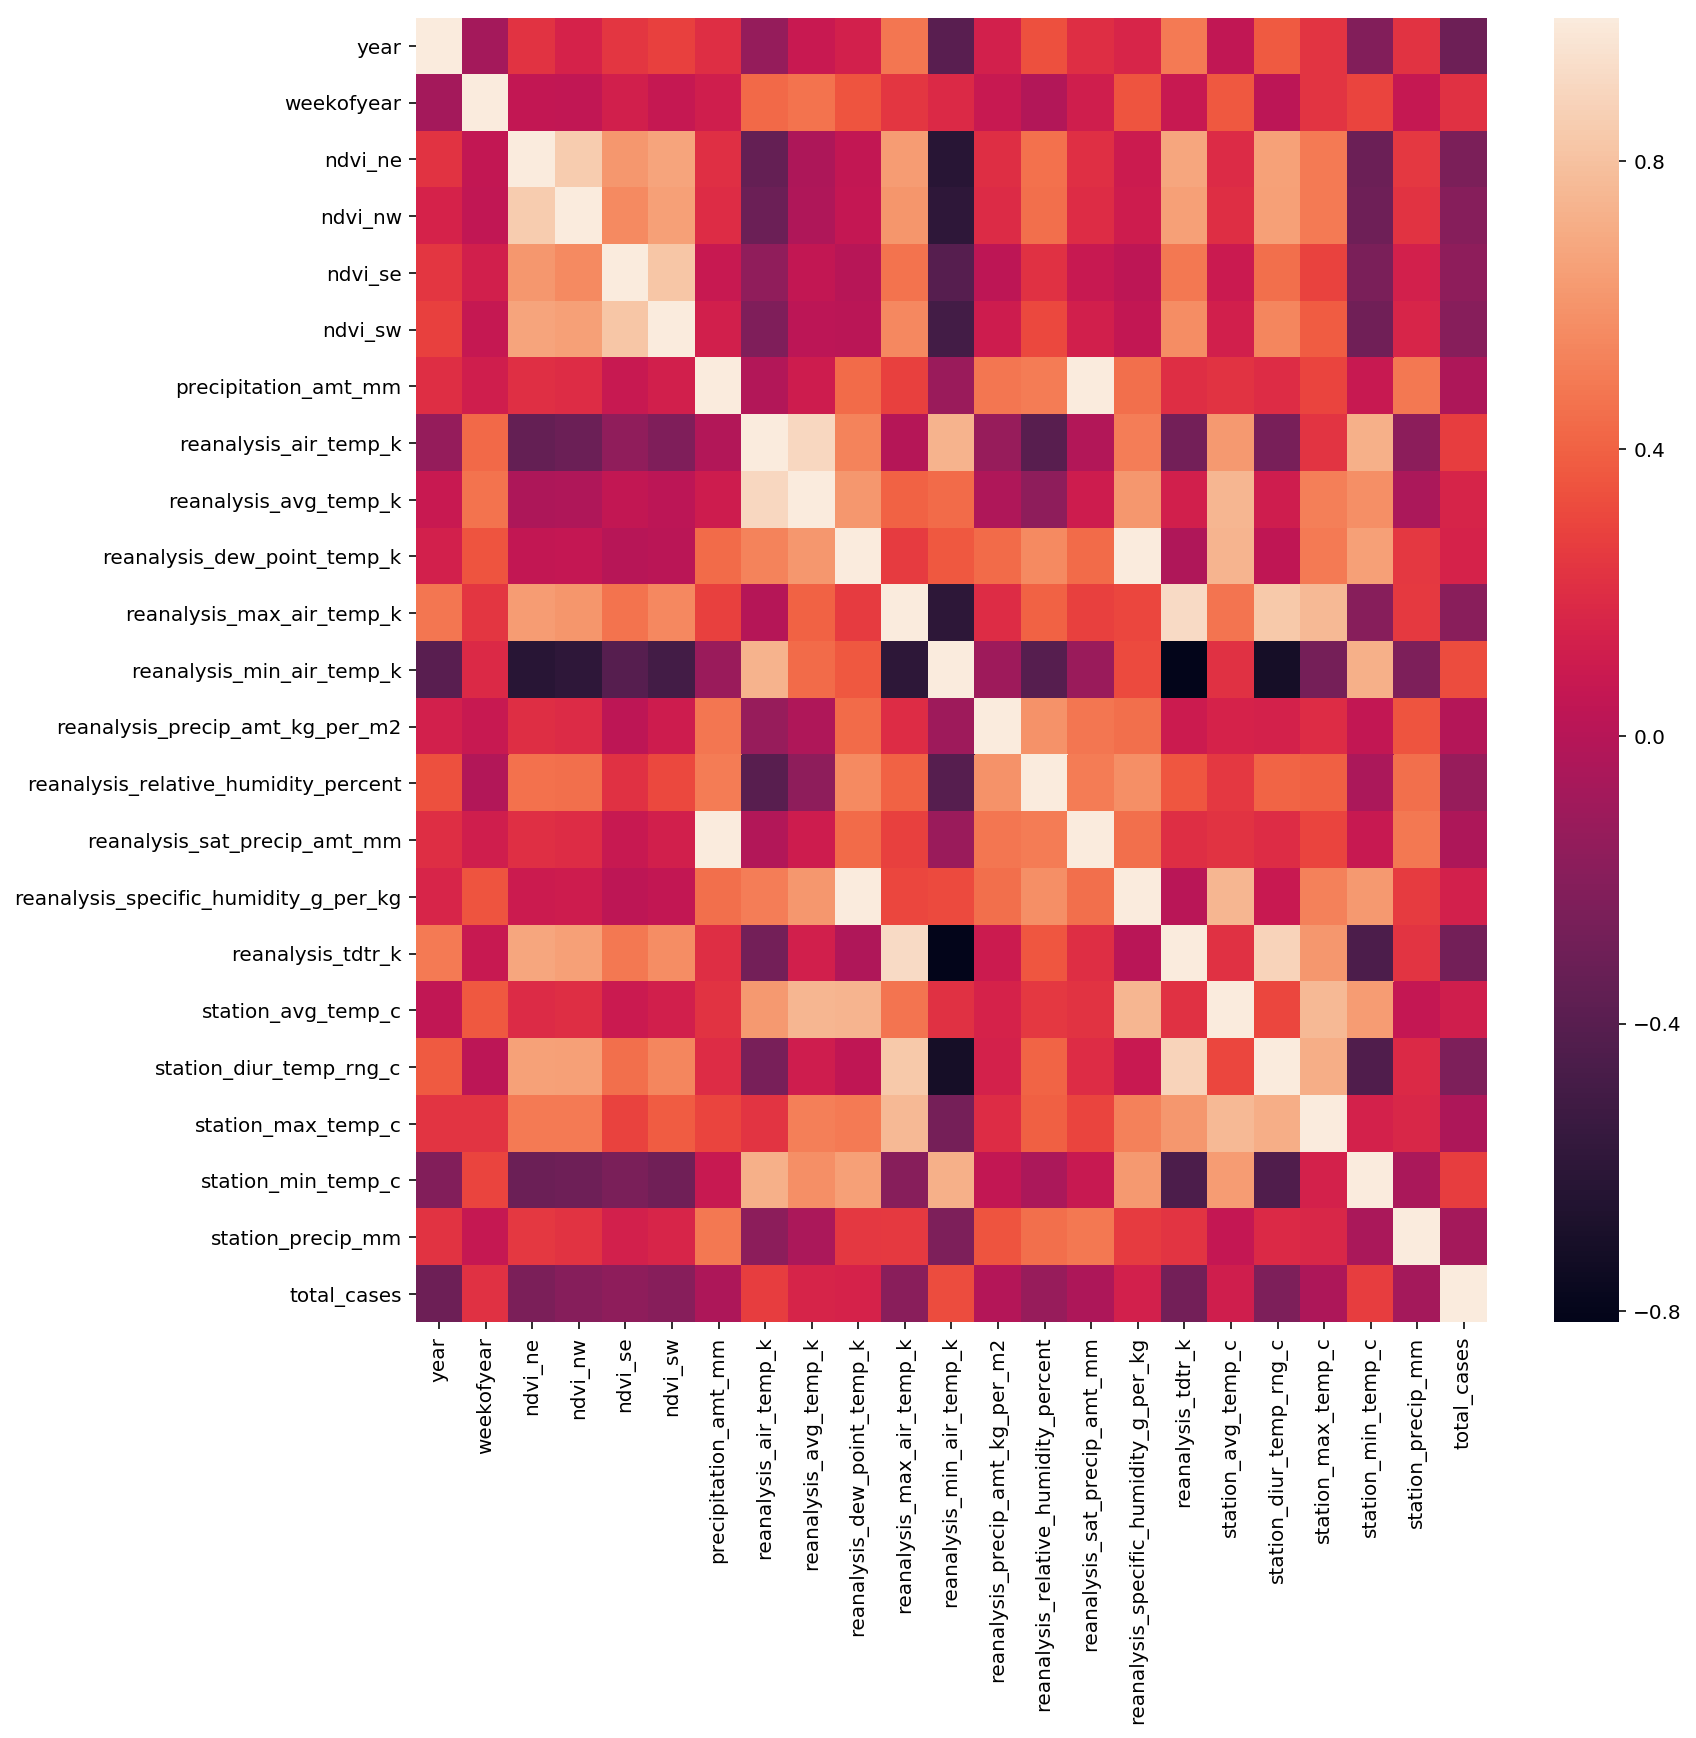

In [16]:
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(train.corr(), ax=ax);

In [17]:
train = train.drop(columns=['city', 'week_start_date'], axis=1)

In [73]:
train.columns

Index(['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
for train_index, test_index in split.split(train, train['weekofyear']):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

In [19]:
X_train, X_test = strat_train_set.copy(), strat_test_set.copy()

Y_train, Y_test = X_train['total_cases'], X_test['total_cases']
X_train.drop(columns=['total_cases'], inplace=True)
X_test.drop(columns=['total_cases'], inplace=True)

In [60]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline

preproc_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

_X_train = preproc_pipeline.fit_transform(X_train)
X_train = pd.DataFrame(_X_train, columns=X_train.columns)

_X_test = preproc_pipeline.fit_transform(X_test)
X_test = pd.DataFrame(_X_test, columns=X_test.columns)

In [61]:
from sklearn.feature_selection import SelectKBest, f_regression

predictors = X_train.columns.tolist()

selector = SelectKBest(f_regression, k=5)
selector.fit(X_train[predictors], Y_train)

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

scores = pd.DataFrame(scores, index=predictors, columns=['Score'])
best_features = scores.loc[scores['Score'] > scores.values.mean()].index

In [74]:
best_features

Index(['year', 'weekofyear', 'reanalysis_air_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_tdtr_k', 'station_diur_temp_rng_c', 'station_min_temp_c'],
      dtype='object')

In [62]:
X_train[best_features];

In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [64]:
from sklearn.metrics import mean_absolute_error

Y_train_preds = lin_reg.predict(X_train)
lin_mae = mean_absolute_error(Y_train, Y_train_preds)
lin_mae

19.4263582298883

In [65]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, Y_train)
Y_train_preds = tree_reg.predict(X_train)
tree_mae = mean_absolute_error(Y_train, Y_train_preds)
tree_mae

0.0

In [80]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, Y_train)
Y_test_preds = forest_reg.predict(X_test)
forest_mae = mean_absolute_error(Y_test, Y_test_preds)
forest_mae

20.886486486486486

In [67]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'n_estimators' : [5,10,15,20],
        'max_features' : [2, 4, 6, 8],
        'bootstrap' : [True, False]
    
    }
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, Y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 15, 20], 'max_features': [2, 4, 6, 8], 'bootstrap': [True, False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [68]:
cv_results = grid_search.cv_results_
for mae, params in zip(cv_results['mean_test_score']*-1, cv_results['params']):
    print(mae, params)

18.461743589743588 {'bootstrap': True, 'max_features': 2, 'n_estimators': 5}
18.008205128205127 {'bootstrap': True, 'max_features': 2, 'n_estimators': 10}
17.325538461538464 {'bootstrap': True, 'max_features': 2, 'n_estimators': 15}
17.610205128205124 {'bootstrap': True, 'max_features': 2, 'n_estimators': 20}
18.71117948717949 {'bootstrap': True, 'max_features': 4, 'n_estimators': 5}
17.356717948717947 {'bootstrap': True, 'max_features': 4, 'n_estimators': 10}
16.744752136752133 {'bootstrap': True, 'max_features': 4, 'n_estimators': 15}
16.833538461538463 {'bootstrap': True, 'max_features': 4, 'n_estimators': 20}
19.292102564102564 {'bootstrap': True, 'max_features': 6, 'n_estimators': 5}
16.305538461538465 {'bootstrap': True, 'max_features': 6, 'n_estimators': 10}
16.314393162393163 {'bootstrap': True, 'max_features': 6, 'n_estimators': 15}
16.531743589743588 {'bootstrap': True, 'max_features': 6, 'n_estimators': 20}
17.57271794871795 {'bootstrap': True, 'max_features': 8, 'n_estimato

In [71]:
# from sklearn.model_selection import RandomizedSearchCV

# random_grid = {
#     'n_estimators' : [int(x) for x in np.linspace(200,2000,10)],
#     'max_features' : ['auto', 'sqrt'],
#     'max_depth' : [int(x) for x in np.linspace(10,110,11)] + [None],
#     'min_samples_split' : [2,5,10],
#     'min_samples_leaf' : [1,2,4],
#     'bootstrap' : [True, False]
# }

# rf = RandomForestRegressor()

# rf_random = RandomizedSearchCV(estimator=rf, 
#                                param_distributions=random_grid, 
#                                n_iter=50, cv=3, verbose=2,
#                               random_state=42, n_jobs=-1)

# rf_random.fit(X_train, X_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.5s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   1.5s
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, t

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   4.1s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=   8.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  23.7s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  24.0s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators

KeyboardInterrupt: 

In [82]:
from xgboost import XGBRegressor

xg_reg = XGBRegressor()
xg_reg.fit(X_train, Y_train)
Y_preds = xg_reg.predict(X_test)
xg_mae = mean_absolute_error(Y_test, Y_preds)
xg_mae

21.577271943032866

In [29]:
param_grid = [
    {
        'max_depth' : [7],
        'min_child_weight' : [1,3,5,10,15],
        'n_estimators' : [25, 50, 100, 200]
    
    }
]

xg_reg = XGBRegressor(learning_rate=0.1)

grid_search = GridSearchCV(xg_reg, param_grid, cv=5, scoring='neg_mean_absolute_error', verbose=1, return_train_score=True, n_jobs=-1)

grid_search.fit(X_train_proc, Y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'max_depth': [7], 'min_child_weight': [1, 3, 5, 10, 15], 'n_estimators': [25, 50, 100, 200]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

In [30]:
cv_results = grid_search.cv_results_
for mae, params in zip(cv_results['mean_test_score']*-1, cv_results['params']):
    print(mae, params)

11.91650981695224 {'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 25}
11.8127550192674 {'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 50}
11.841739718883465 {'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100}
11.850568322738011 {'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200}
11.914507835278144 {'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 25}
11.841159526476494 {'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 50}
11.880313960130398 {'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100}
11.886073729777948 {'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200}
12.67921072819294 {'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 25}
12.936876655633633 {'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 50}
13.039263317279326 {'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 100}
13.075212392593041 {'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 200}
13.540128247554486 {'max_depth': 7, 'min_child_wei